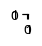

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [2]:
# Load models together
from src.torch_utils import load_model_full
from src.metrics import compute_cosine_distance
from src.utils import get_class_initcode_keys
from src.models import BimodalVAEClassifier, FullTCRVAE, PeptideClassifier
from src.datasets import BimodalTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
pos_df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
mix_df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')


def get_model(folder):
    pt = glob.glob(folder+'/*.pt')[0]
    js = glob.glob(folder+'/*.json')[0]
    model = load_model_full(pt, js, return_json=False, verbose=False)
    return model
    

# Redefine multimodal as : Pep - TCR:Pep - TCR

For full TCR ; 

- TCR with no pep can be healthy negatives for example
- Pep with no TCR can be from IEDB for example...

In [391]:
import glob
tcrpep_df = pd.read_csv('../data/filtered/231212_nettcr_expanded_pairedAB_412peps_with_swaps.csv').assign(db='nettcr').query('not origin.str.contains("swapped")')
tcr_df = pd.concat([pd.read_csv(x, sep='\t') for x in glob.glob('../data/immrep/*.tsv')]).assign(db='immrep_negs')
tcr_df = tcr_df[['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'db']].assign(peptide='XXXXXXXXX')


df = tcrpep_df.query('origin!="peptide_swapped" and input_type=="paired"')
df['peplen'] = df['peptide'].apply(len)
fracdict = (df.groupby('peplen').agg(count=('B3','count')) / len(df)).to_dict()['count']

randompeps = pd.concat([pd.read_csv(x, header=None, names=['peptide']) for x in glob.glob('../data/multimodal/randompeps/*randompeps_*.pep')])
randompeps['len'] = randompeps['peptide'].apply(len)
sample = randompeps.groupby('len', group_keys=False).apply(lambda x: x.sample(frac=fracdict[x.len.unique()[0]], random_state=13))
sample.to_csv('../data/multimodal/randompeps_8_12_lenSampled_1M.txt', index=False)

# Maybe use some of our neoepitope and viral and human peptides from CEDAR + PRIME + IEDB + NEPDB etc
viral = pd.read_csv('../../cedar_icerfire/data/heli_viral', sep =' ', usecols=['Icore', 'Rnk_EL', 'allele', 'id', 'uniprot_id', 'target', 'peptide_length', 'prot_sequence', 'peptide_start'])
human = pd.read_csv('../../cedar_icerfire/data/human_proteome/human_sample_100k.csv')
cedar = pd.read_csv('../../cedar_icerfire/data/aligned_icore/230418_cedar_aligned.csv')
prime = pd.read_csv('../../cedar_icerfire/data/aligned_icore/230418_prime_aligned.csv')
nepdb = pd.read_csv('../../cedar_icerfire/data/aligned_icore/230418_nepdb_aligned.csv')
viral = viral.rename(columns={'Icore':'peptide', 'Rnk_EL':'EL_rank',
              'peptide_length':'peplen', 'allele':'HLA'})\
             .assign(db='viral', input_type='peptide')\
             .drop(columns=['prot_sequence','id'])[['peptide','HLA','target','EL_rank', 'peplen','db','uniprot_id','peptide_start']]
human = human[['icore_mut','HLA', 'EL_rank_mut']].rename(columns={'icore_mut':'peptide', 'EL_rank_mut':'EL_rank'}).assign(target=0).assign(db='human', input_type='peptide')
cedar = cedar[['icore_mut','HLA', 'EL_rank_mut', 'agg_label']].rename(columns={'icore_mut':'peptide', 'EL_rank_mut':'EL_rank', 'agg_label':'target'}).assign(db='cedar', input_type='peptide')
prime = prime[['icore_mut','HLA', 'EL_rank_mut', 'agg_label']].rename(columns={'icore_mut':'peptide', 'EL_rank_mut':'EL_rank', 'agg_label':'target'}).assign(db='prime', input_type='peptide')
nepdb = nepdb[['icore_mut','HLA', 'EL_rank_mut', 'agg_label']].rename(columns={'icore_mut':'peptide', 'EL_rank_mut':'EL_rank', 'agg_label':'target'}).assign(db='nepdb', input_type='peptide')

peptide_data = pd.concat([viral, human, cedar, prime, nepdb]).assign(input_type='peptide')
peptide_data = peptide_data.drop_duplicates(['peptide'])
peptide_data['peplen'] = peptide_data['peptide'].apply(len)
peptide_data.to_csv('../data/multimodal/240311_merged_peptides.csv', index=False)
# Duplicates in tcr_df
tcr_df.drop_duplicates(['A1', 'A2', 'A3', 'B1', 'B2', 'B3']).reset_index(drop=True).to_csv('../data/multimodal/240311_immrepnegs_tcrs.csv', index=False)
tcrpep_df.to_csv('../data/multimodal/240311_nettcr_pairedAB_expanded_noswap.csv', index=False)

### (bad) partitioning

In [368]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import StratifiedKFold


def read_hobohm(filename, original_df, pep_col='Peptide', hla_col='HLA', elrank_col='trueHLA_EL_rank',
                target_col='agg_label'):
    """
    Reads the output of a hobohm reduced file
    (ex would read "dataset.out" from ./hobohm1_pepkernel input.pep > dataset.out
    Args:
        filename: Filepath to the output file of the hobohm script
        original_df: DataFrame or the path to the original dataframe used to run Hobohm
        pep_col : Column of DataFrame containing the Peptide
        hla_col : Column of DataFrame containing the HLA
        elrank_col : Column of DataFrame containing the ELrank
    Returns:
        unique_df (pd.DataFrame): DataFrame containing the unique sequences
        not_unique_df (pd.DataFrame): DataFrame containing the non-unique sequences
    """
    assert type(original_df) in [pd.DataFrame, str], 'original_df must be a Pandas DataFrame or a filepath!'
    if type(original_df) != pd.DataFrame:
        try:
            original_df = pd.read_csv(original_df)
        except:
            raise ValueError(f"Couldn't read or access {original_df} of type {type(original_df)}!")
    # Get unique df and merge to original df;
    # Given Hobohm, all identical sequences with different HLA should re-appear and will need to be
    # addressed later in another function
    unique_df = pd.read_csv(filename, header=None, comment='#')
    unique_df.columns = [pep_col]
    unique_df = unique_df.merge(original_df[[pep_col, hla_col, elrank_col, target_col]],
                                left_on=pep_col, right_on=pep_col)

    with open(filename, 'r') as f:
        lines = [l.strip('\n') for l in f.readlines()]
    # Get the non-unique saved somewhere to re-assign them later
    values = []
    for l in lines:
        if 'Not unique' not in l: continue
        l = l.replace('\n', '')
        l = [x.split(' ') for x in l.split('# Not unique. ')[1].split(' is similar to ')]
        idx = l[0][0]
        discarded = l[0][1]
        similar = l[1][0]
        similarity_score = l[1][1]
        values.append([idx, similar, discarded, similarity_score])
    not_unique_df = pd.DataFrame(values, columns=['drop_idx', 'similar', 'discarded', 'similarity_score'])
    not_unique_df['self'] = not_unique_df['similar'] == not_unique_df['discarded']
    return unique_df, not_unique_df


def manually_reassign_identical(k, unique_df, pep_col='Peptide'):
    """
    Assumes the unique_df contains identical sequences with different HLAs due to the previous merge operation.
    Assumes the unique_df has already been KFold separated. Then, identical sequences with different HLAs will be reassigned
    to the same fold.
    Args:
        k: K in K fold
        unique_df: The unique_df that has previously been kfold split
        pep_col: column containing the Peptide

    Returns:
        unique_df: The unique_df that has undergone re-assignment
    """

    assignment_counts = {x: 0 for x in range(k)}
    # Go through all the duplicated peps
    for pep in unique_df.loc[unique_df.duplicated(pep_col, keep=False)][pep_col].unique():
        tmp = unique_df.loc[unique_df[pep_col] == pep]
        # if already all the same fold then it's fine, continue
        if len(tmp.fold.unique()) == 1: continue
        # otherwise: assign to a fold that has the least assignments (starts at 0)
        counts = [assignment_counts[k] for k in tmp.fold.values]
        new_assignment = tmp.fold.values[counts.index(min(counts))]
        unique_df.loc[unique_df[pep_col] == pep, 'fold'] = new_assignment
        assignment_counts[new_assignment] += 1
    return unique_df


def manually_reassign_related(unique_df, not_unique_df, pep_col='Peptide', hla_col='HLA', elrank_col='trueHLA_EL_rank',
                              target_col='agg_label'):
    """
    Manually reassigns non-unique (discarded) peptide to the same fold as their related pep
    Args:
        unique_df (pd.DataFrame): DataFrame containing the unique sequences
        not_unique_df (pd.DataFrame): DataFrame containing the non-unique sequences
        pep_col: Column of DataFrame containing the Peptide
        hla_col: Column of DataFrame containing the HLA
        elrank_col: Column of DataFrame containing the ELrank
    Returns:
        not_unique-df (pd.DataFrame): Non-unique DataFrame with sequences re-assigned to the correct fold
    """
    # Re-assigning
    not_unique_df['fold'] = not_unique_df.apply(lambda x: unique_df.query(f'{pep_col}==@x.similar')['fold'].unique()[0],
                                                axis=1)
    not_unique_df = not_unique_df[['discarded', target_col, hla_col, elrank_col, 'fold']].rename(
        columns={'discarded': pep_col})

    return not_unique_df


def stratified_kfold_unique(unique_df, not_unique_df, original_df,
                     k=5, shuffle=True, seed=13,
                     pep_col='Peptide', hla_col='HLA', elrank_col='trueHLA_EL_rank', target_col='agg_label'):
    # Stratify KFold on the unique set, based on duplicated counts as stratifying group.
    # Then repopulate the folds with
    not_unique_df['drop_idx'] = not_unique_df['drop_idx'].astype(int)
    # Get the strat KF object
    stratkf = StratifiedKFold(k, shuffle=shuffle, random_state=seed)
    # Merge the not unique (to get agg_label, i.e. "y" for stratkf to split and get the duplicated counts
    not_unique_df = not_unique_df.merge(original_df.reset_index()[['index', target_col, hla_col, elrank_col]],
                                     left_on='drop_idx', right_on='index')

    dup_counts = not_unique_df.groupby('similar').agg({'self': 'count'})\
                              .sort_values('self', ascending=False).reset_index()

    dup_counts = dup_counts.merge(unique_df[[pep_col, target_col]], left_on='similar',
                                  right_on=pep_col).drop_duplicates(['similar', target_col])
    # Merge and assign the duplicated counts, to be used as stratify groups
    unique_df['counts'] = 0
    tmp = unique_df.reset_index().merge(dup_counts[[pep_col, 'self']], left_on=pep_col, right_on=pep_col)
    unique_df.iloc[tmp['index'].values, unique_df.columns.get_loc('counts')] = tmp['self']

    # Ready to stratify and set the folds
    unique_df['fold'] = np.nan
    for i, (train_idx, test_idx) in enumerate(
            stratkf.split(unique_df[pep_col].values, unique_df[target_col], groups=unique_df['counts'])):
        unique_df.iloc[test_idx, unique_df.columns.get_loc('fold')] = i
    unique_df.fold = unique_df.fold.astype(int)
    return unique_df, not_unique_df


def pipeline_stratified_kfold(hobohm_filename, original_df, k=5, shuffle=True, seed=13, fuckyou=False,
                              pep_col='Peptide', hla_col='HLA', elrank_col='trueHLA_EL_rank', target_col='agg_label'):
    """

    Args:
        hobohm_filename:
        original_df:
        k:
        shuffle:
        seed:
        pep_col:
        hla_col:
        elrank_col:

    Returns:
        dataset (pd.DataFrame): dataset with assigned folds
    """
    # original_df = original_df.sort_values(pep_col).reset_index(drop=True)
    print('start', len(original_df))
    unique_df, not_unique_df = read_hobohm(hobohm_filename, original_df, pep_col, hla_col, elrank_col, target_col)
    print('read hobohm', len(unique_df), len(not_unique_df))
    unique_df, not_unique_df = stratified_kfold_unique(unique_df, not_unique_df, original_df, k, shuffle, seed,
                                                pep_col, hla_col, elrank_col, target_col )
    print('strat kfold unique', len(unique_df), len(not_unique_df))
    unique_df = manually_reassign_identical(k, unique_df, pep_col)
    print('manually reassign identical', len(unique_df), len(not_unique_df))
    not_unique_df = manually_reassign_related(unique_df, not_unique_df, pep_col, hla_col, elrank_col, target_col)
    print('manually reassign related', len(unique_df), len(not_unique_df))
    dataset = pd.concat([unique_df, not_unique_df], ignore_index=True) \
        .sort_values(pep_col, ascending=True).reset_index(drop=True).drop(columns=['counts'])
    print('concat', len(dataset))
    merge_cols = [pep_col, hla_col]
    merge_cols.extend(original_df.columns.difference(dataset.columns))
    if fuckyou:
        return dataset, merge_cols
    else:
        dataset = dataset.merge(original_df[merge_cols], left_on=[pep_col, hla_col], right_on=[pep_col, hla_col])
        print('merge', len(dataset))
    
        # Bugfix: Drops some unique that were duplicated during the manual re-assignment
        dataset = dataset.drop(dataset.loc[dataset.duplicated(keep='first')].index)
        print('drop duplicated', len(dataset))
        return dataset


In [311]:
# Make seqsim% partition for peptide data
peptide_data['peptide'].to_csv('../../kern_dist/data/240314_merged_peps.txt', index=False, header=False)
# What about TCRS df ?..

In [319]:
peptide_data = peptide_data.sort_values('peptide').reset_index(drop=True)
peptide_data.query('db!="human"')['peptide'].to_csv('../../kern_dist/data/240314_merged_peps.txt', index=False, header=False)

In [345]:
pepkf  = pipeline_stratified_kfold('../../kern_dist/240314_merged_peps.txt_0.9.out', 
                                  peptide_data.query('db!="human"').reset_index(drop=True).sort_values('peptide'), 
                                  pep_col='peptide', hla_col='HLA', elrank_col='EL_rank', target_col='target')

start 13639
read hobohm 11072 2567
strat kfold unique 11072 2567
manually reassign identical 11072 2567
manually reassign related 11072 2567
concat 13639
merge 13639
drop duplicated 13639


In [346]:
pepkf

,peptide,HLA,EL_rank,target,fold,db,input_type,peplen,peptide_start,uniprot_id
0,AAAAAAAVL,HLA-B0702,0.9883,0,0,prime,peptide,9,NaN,NaN
1,AAAAAAQQI,HLA-B0702,3.9712,0,0,cedar,peptide,9,NaN,NaN
2,AAAALHMQR,HLA-A1101,0.3609,0,0,prime,peptide,9,NaN,NaN
3,AAAAQQIQV,HLA-B0702,4.9092,0,4,cedar,peptide,9,NaN,NaN
4,AAASSSVQR,HLA-A1101,0.1820,0,2,prime,peptide,9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
13634,YYVGHKAKF,HLA-A2402,0.0238,1,0,cedar,peptide,9,NaN,NaN
13635,YYVGYLQPRTF,HLA-A2402,0.0580,0,4,viral,peptide,11,264.0,P0DTC2
13636,YYVIYEAVI,HLA-A2301,0.6590,0,0,viral,peptide,9,79.0,P68599
13637,YYVKEYNTY,HLA-A2301,0.1520,0,0,viral,peptide,9,413.0,P21047


In [433]:
tcr_df['cdr23']=tcr_df['A2']+tcr_df['A3']+tcr_df['B2']+tcr_df['B3']
tcr_df['cdr3'] = tcr_df['A3']+tcr_df['B3']
tcr_df = tcr_df.sort_values('cdr23').reset_index(drop=True).drop_duplicates(['A1', 'A2', 'A3', 'B1', 'B2', 'B3'])
# use 0.98 threshold with cdr 23
tcr_df['cdr23'].to_csv('../../kern_dist/data/240314_tcr_immreps_cdr23.txt', index=False, header=False)
tcr_df['cdr3'].to_csv('../../kern_dist/data/240314_tcr_immreps_cdr3.txt', index=False, header=False)

In [436]:
# tcr_df['cdr23']=tcr_df['A3']+tcr_df['B3']
tcr_df['fake_rank'] = torch.rand((len(tcr_df),))
tcr_df['fake_target'] = torch.randint(0, 2, (len(tcr_df),))
tcr_df = tcr_df.sort_values('cdr3').reset_index(drop=True)

a,b = pipeline_stratified_kfold('../../kern_dist/240314_tcr_immreps_cdr3.txt_0.972.out', tcr_df.reset_index(drop=True),
                            fuckyou=True, seed=13,
                              pep_col='cdr3', hla_col='A3', elrank_col='fake_rank', target_col='fake_target')
tcrkf = a.sort_values(['cdr3', 'A3']).reset_index(drop=True)[['fold']].merge(tcr_df.sort_values(['cdr3', 'A3']).reset_index(drop=True), 
                                                       left_index=True, right_index=True)
tcrkf = tcrkf.drop_duplicates(['A1', 'A2', 'A3', 'B1', 'B2', 'B3']).drop(columns=['cdr3'])
display(tcrkf.groupby('fold').count())

start 15118
read hobohm 14024 1106
strat kfold unique 14024 1106
manually reassign identical 14024 1106
manually reassign related 14024 1106
concat 15130


,A1,A2,A3,B1,B2,B3,db,peptide,fake_rank,fake_target,cdr23
fold,,,,,,,,,,,
0,3021,3021,3021,3021,3021,3021,3021,3021,3021,3021,3021
1,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051
2,3030,3030,3030,3030,3030,3030,3030,3030,3030,3030,3030
3,3016,3016,3016,3016,3016,3016,3016,3016,3016,3016,3016
4,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000


### Saving

In [438]:
len(pepkf), len(tcrkf), len(tcrpep_df)

(13639, 15118, 9769)

In [439]:
tcrkf.groupby('fold').count()

,A1,A2,A3,B1,B2,B3,db,peptide,fake_rank,fake_target,cdr23
fold,,,,,,,,,,,
0,3021,3021,3021,3021,3021,3021,3021,3021,3021,3021,3021
1,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051
2,3030,3030,3030,3030,3030,3030,3030,3030,3030,3030,3030
3,3016,3016,3016,3016,3016,3016,3016,3016,3016,3016,3016
4,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000


In [440]:
pepkf.groupby('fold').count()

,peptide,HLA,EL_rank,target,db,input_type,peplen,peptide_start,uniprot_id
fold,,,,,,,,,
0,2750,2750,2750,2750,2750,2750,2750,1795,1795
1,2714,2714,2714,2714,2714,2714,2714,1752,1752
2,2700,2700,2700,2700,2700,2700,2700,1711,1711
3,2713,2713,2713,2713,2713,2713,2713,1741,1741
4,2762,2762,2762,2762,2762,2762,2762,1763,1763


In [446]:
tcrpep_df.to_csv('../data/multimodal/240314_tcrpep_df.csv', index=False)
pepkf.to_csv('../data/multimodal/240314_pepkf.csv', index=False)
tcrkf.to_csv('../data/multimodal/240314_tcrkf.csv', index=False)

In [452]:
multimodal_df = pd.concat([tcrpep_df.assign(input_type='tcr_pep'), 
                           pepkf.assign(input_type='pep').rename(columns={'fold':'partition'}),
                           tcrkf.assign(input_type='tcr').rename(columns={'fold':'partition'})])[['peptide', 'A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'allele', 'binder', 'target', 'partition', 'input_type', 'db']]
multimodal_df['A1'].fillna('X'*7, inplace=True)
multimodal_df['A2'].fillna('X'*8, inplace=True)
multimodal_df['A3'].fillna('X'*22, inplace=True)
multimodal_df['B1'].fillna('X'*6, inplace=True)
multimodal_df['B2'].fillna('X'*7, inplace=True)
multimodal_df['B3'].fillna('X'*23, inplace=True)

In [453]:
display(multimodal_df.groupby('partition').count())
multimodal_df.query('db!="human"').to_csv('../data/multimodal/240314_multimodal_NO_HUMAN_tcr_pep.csv', index=False)
multimodal_df

,peptide,A1,A2,A3,B1,B2,B3,allele,binder,target,input_type,db
partition,,,,,,,,,,,,
0,7732,7732,7732,7732,7732,7732,7732,1961,1961,2750,7732,7732
1,7722,7722,7722,7722,7722,7722,7722,1957,1957,2714,7722,7722
2,7675,7675,7675,7675,7675,7675,7675,1945,1945,2700,7675,7675
3,7678,7678,7678,7678,7678,7678,7678,1949,1949,2713,7678,7678
4,7719,7719,7719,7719,7719,7719,7719,1957,1957,2762,7719,7719


,peptide,A1,A2,A3,B1,B2,B3,allele,binder,target,partition,input_type,db
3,TTDPSFLGRY,ATGYPS,ATKADDK,ALSGNTDKLI,MDHEN,SYDVKM,ASSLAGGIVDEQF,HLA-A*01:01,1.0,NaN,1,tcr_pep,nettcr
16,RLPGVLPRA,SSVSVY,YLSGSTLV,AVSPYNNNDMR,SGHNS,FNNNVP,ASRPLAAQETQY,HLA-A*02:01,1.0,NaN,4,tcr_pep,nettcr
34,LLDFVRFMGV,KTLYG,LQKGGEE,GADGNFNKFY,MNHEY,SVGAGI,ASSQWGQGRETQY,HLA-A*02:01,1.0,NaN,4,tcr_pep,nettcr
42,VYFLQSINF,SSVSVY,YLSGSTLV,AVSTNTGANSKLT,SGHDT,YYEEEE,ASSFRGLNQPQH,"HLA-A*02:01, HLA-A*24:02",1.0,NaN,3,tcr_pep,nettcr
49,ELAGIGILTV,DRGSQS,IYSNGD,AAPQGAGTALI,LGHNA,YSLEER,ASSRALLMGNTIY,HLA-A*02:01,1.0,NaN,1,tcr_pep,nettcr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,XXXXXXXXX,DSASNY,IRSNVGE,WDNYGGSQGNLI,MGHDK,SYGVNS,ASSVRYEQY,NaN,NaN,NaN,0,tcr,immrep_negs
15114,XXXXXXXXX,SVFSS,VVTGGEV,YGYALN,MDHEN,SYDVKM,ASTTFTGSNYGYT,NaN,NaN,NaN,1,tcr,immrep_negs
15115,XXXXXXXXX,DSAIYN,IQSSQRE,YLDMR,SGHVS,FQNEAQ,ASSLSGTSTDTQY,NaN,NaN,NaN,4,tcr,immrep_negs
15116,XXXXXXXXX,SIFNT,LYKAGEL,YNDMR,LNHDA,SQIVND,ASSGTGVVGELF,NaN,NaN,NaN,1,tcr,immrep_negs


# Define supervision level as % paired data vs total & deal with batching ?

In [160]:
multimodal_df.input_type.unique()

array(['tcr_pep', 'pep', 'tcr'], dtype=object)

In [156]:
data_size = 16000
n_sample = 10000

indices = torch.randperm(data_size)
sampled_indices = indices[:n_sample]
sampled_indices, len(sampled_indices.unique())

(tensor([ 4150, 15840, 14944,  ...,  1427, 13464,  7171]), 10000)

In [163]:
x = torch.empty([100, 78, 20])
x[:, :60, : ].shape

torch.Size([100, 60, 20])

In [186]:
torch.randperm(100)[:10]

tensor([78, 90, 84,  8, 69, 55, 67, 48, 64, 15])

In [203]:
from src.datasets import MultimodalPepTCRDataset
from torch.utils.data import SequentialSampler
ds = MultimodalPepTCRDataset(multimodal_df.query('db!="human"'))
dl = ds.get_dataloader(1024, SequentialSampler)
for b in dl:
    pass

In [211]:
import torch

def tanh_weight_scale(x, scale=1.0, shift=0.0):
    """
    Compute a scaled and shifted tanh function to be used for a weight factor.
    
    Parameters:
    - x: The input tensor.
    - scale: The scale factor to adjust the ramp-up speed.
    - shift: The shift factor to adjust when the ramp-up starts.
    
    Returns:
    - A tensor with values smoothly transitioned from 0 to 1.
    """
    return 0.5 * (1 + torch.tanh(scale * (x - shift)))


In [213]:
weight_factor = tanh_weight_scale(5, scale=0.1, shift=25)


TypeError: tanh(): argument 'input' (position 1) must be Tensor, not float

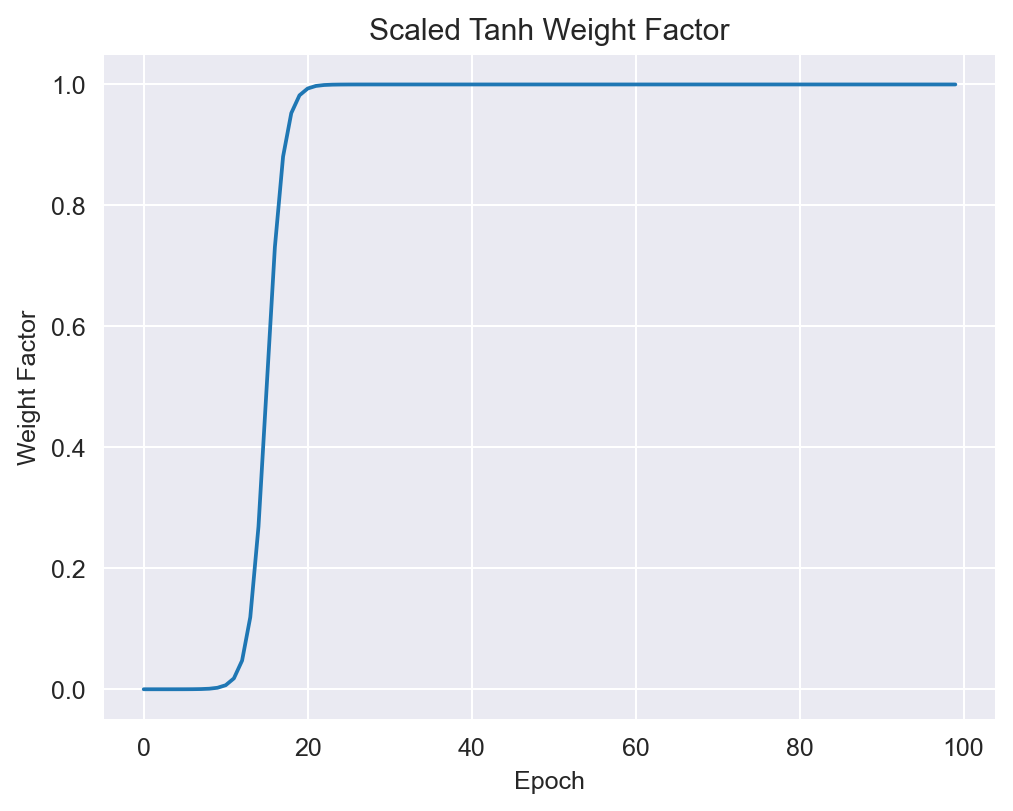

In [221]:

# Example usage
epochs = torch.arange(100)  # Simulate epoch numbers from 0 to 99
weight_factor = tanh_weight_scale(epochs, scale=0.5, shift=15)

# Plotting for visualization
import matplotlib.pyplot as plt

plt.plot(epochs.numpy(), weight_factor.numpy())
plt.title("Scaled Tanh Weight Factor")
plt.xlabel("Epoch")
plt.ylabel("Weight Factor")
plt.grid(True)
plt.show()

In [195]:
ds.tcr_indices

tensor([15875,  5716, 10470,  ...,  9178, 14856,  1519])

In [207]:
ds.increment_counter()
ds.tcr_indices
for b1 in dl:
    pass

In [209]:
b1[0][:10]

tensor([[[ -2.,  -2.,   2.,  ...,  -5.,  -3.,  -4.],
         [  1.,  -1.,   1.,  ...,  -4.,  -2.,  -2.],
         [  5.,  -2.,  -1.,  ...,  -3.,  -2.,   0.],
         ...,
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.]],

        [[  0.,  -3.,  -3.,  ...,  -3.,  -1.,   5.],
         [  1.,  -1.,   1.,  ...,  -4.,  -2.,  -2.],
         [  0.,  -3.,   0.,  ...,  -3.,  -3.,  -4.],
         ...,
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.]],

        [[  0.,  -1.,   0.,  ...,  -3.,  -2.,   0.],
         [ -2.,   7.,  -1.,  ...,  -3.,  -1.,  -3.],
         [ -2.,  -2.,   2.,  ...,  -5.,  -3.,  -4.],
         ...,
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.],
         [-20., -20., -20.,  ..., -20., -20., -20.]],

In [308]:
multimodal_df.groupby('partition').count()

,peptide,A1,A2,A3,B1,B2,B3,allele,binder,target,input_type,db
partition,,,,,,,,,,,,
0.0,1961,1961,1961,1961,1961,1961,1961,1961,1961,0,1961,1961
1.0,1957,1957,1957,1957,1957,1957,1957,1957,1957,0,1957,1957
2.0,1945,1945,1945,1945,1945,1945,1945,1945,1945,0,1945,1945
3.0,1949,1949,1949,1949,1949,1949,1949,1949,1949,0,1949,1949
4.0,1957,1957,1957,1957,1957,1957,1957,1957,1957,0,1957,1957


In [309]:
multimodal_df

,peptide,A1,A2,A3,B1,B2,B3,allele,binder,target,partition,input_type,db
3,TTDPSFLGRY,ATGYPS,ATKADDK,ALSGNTDKLI,MDHEN,SYDVKM,ASSLAGGIVDEQF,HLA-A*01:01,1.0,NaN,1.0,tcr_pep,nettcr
16,RLPGVLPRA,SSVSVY,YLSGSTLV,AVSPYNNNDMR,SGHNS,FNNNVP,ASRPLAAQETQY,HLA-A*02:01,1.0,NaN,4.0,tcr_pep,nettcr
34,LLDFVRFMGV,KTLYG,LQKGGEE,GADGNFNKFY,MNHEY,SVGAGI,ASSQWGQGRETQY,HLA-A*02:01,1.0,NaN,4.0,tcr_pep,nettcr
42,VYFLQSINF,SSVSVY,YLSGSTLV,AVSTNTGANSKLT,SGHDT,YYEEEE,ASSFRGLNQPQH,"HLA-A*02:01, HLA-A*24:02",1.0,NaN,3.0,tcr_pep,nettcr
49,ELAGIGILTV,DRGSQS,IYSNGD,AAPQGAGTALI,LGHNA,YSLEER,ASSRALLMGNTIY,HLA-A*02:01,1.0,NaN,1.0,tcr_pep,nettcr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,XXXXXXXXX,VGISA,LSSGK,AVRCDTDKLI,GTSNPN,SVGIG,AWGVTDTQY,NaN,NaN,NaN,NaN,tcr,immrep_negs
614,XXXXXXXXX,SIFNT,LYKAGEL,AGKPTGNQFY,GTSNPN,SVGIG,AWSYGGYTEAF,NaN,NaN,NaN,NaN,tcr,immrep_negs
615,XXXXXXXXX,DSASNY,IRSNVGE,AAPPALI,SQVTM,ANQGSEA,SVDGGGTEAF,NaN,NaN,NaN,NaN,tcr,immrep_negs
616,XXXXXXXXX,TSESDYY,QEAYKQQN,AYRTTRDNYGQNFV,LGHNA,YSLEER,ASSQDPAVYNEQF,NaN,NaN,NaN,NaN,tcr,immrep_negs


In [303]:
def batch_generator(x_tensor, batch_size):
    """
    Generator that yields sequential batches from x_tensor, correctly handling the last batch.
    
    Args:
    - x_tensor (Tensor): The input tensor.
    - batch_size (int): The size of each batch.b

    Yields:
    - Tensor: A batch of data.
    """
    num_samples = x_tensor.size(0)
    for start_idx in range(0, num_samples, batch_size):
        # This automatically adjusts to return all remaining data for the last batch
        yield x_tensor[start_idx:start_idx + batch_size]

# Example usage:
x_tensor = torch.randn(10, 3)  # Example tensor with 10 elements and 1000 features
batch_size = 3

for batch in batch_generator(x_tensor, batch_size):
    print(batch.shape)  # Should show (3, 1000) for the first 3 batches and (1, 1000) for the last


torch.Size([3, 3])
torch.Size([3, 3])
torch.Size([3, 3])
torch.Size([1, 3])


In [305]:
len(['a']*20 + ['b']*30 + ['c']*10)

60

# tanh annealing

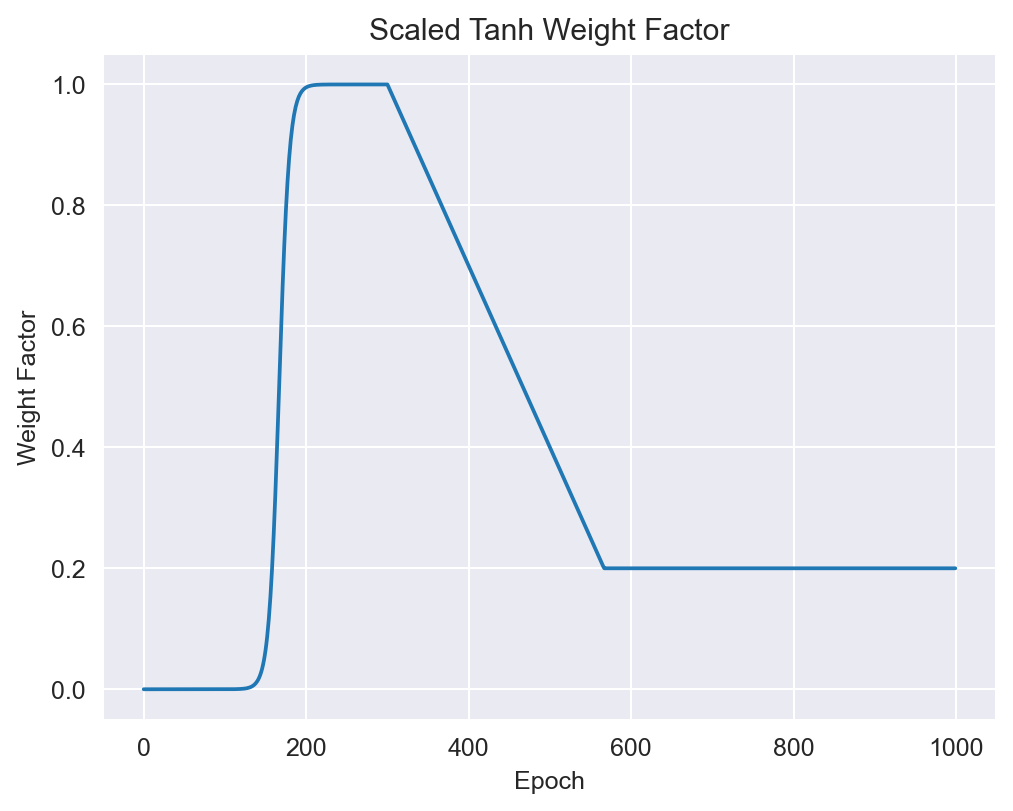

In [463]:
from src.metrics import BSSVAELoss

crit = BSSVAELoss(weight_kld_n=1, kld_warm_up=250, kld_tanh_scale=0.08, flat_phase=50, kld_decrease=3e-3)
x = []

for i in range(1000):
    x.append(crit.weight_kld_n)
    crit.increment_counter()
plt.plot(range(1000), x[:1000])
plt.title("Scaled Tanh Weight Factor")
plt.xlabel("Epoch")
plt.ylabel("Weight Factor")
plt.grid(True)
plt.show()